---
title: PseudoSpectral Difference - 1D
---

In [1]:
import autoroot
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
import finitediffx as fdx
from jaxtyping import Array, Float
# from jaxsw._src.domain.base import Domain
import math
# from jaxsw._src.fields.base import Field
import jax.random as jrandom
import seaborn as sns

jax.config.update("jax_enable_x64", True)
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2

$$
u(x) = \sin(2x) + \frac{1}{2}\cos(5x)
$$

In [2]:
f = lambda x: jnp.sin(2*x) + 0.5*jnp.cos(5*x)
df = jax.grad(f)
d2f = jax.grad(df)

In [3]:

Nx = 32
Lx = 2*math.pi
dx = Lx / Nx

# initialize domains
x_coords = jnp.arange(start=0, stop=Lx, step=dx)
x_plot_coords = jnp.arange(start=0, stop=Lx, step=0.25 * dx)

# initialize fields
u = f(x_coords)
u_plot = f(x_plot_coords)

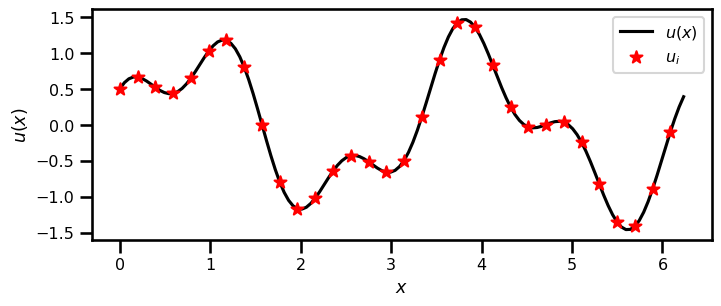

In [4]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(x_plot_coords, u_plot[:], linestyle="-", color="black", label=f"$u(x)$")
ax.scatter(x_coords, u[:], color="r", marker="*", label=f"$u_i$", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$u(x)$")
plt.legend()
plt.show()

### 1st Derivative

In [5]:
df = lambda x: (2.0 * jnp.cos(2.0 * x) - 2.5 * jnp.sin(5.0 * x)).squeeze()

In [6]:
dudx_plot = jax.vmap(df)(x_plot_coords)
dudx_analytical = jax.vmap(df)(x_coords)

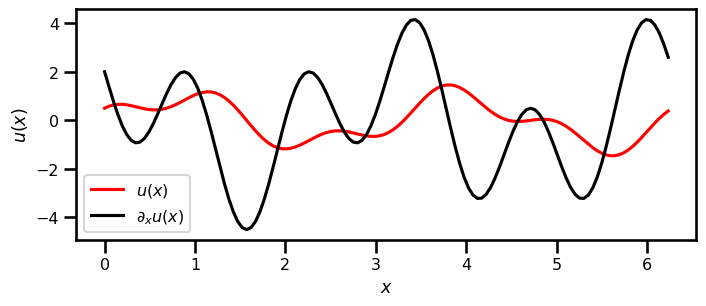

In [7]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(x_plot_coords, u_plot[:], linestyle="-", color="red", label=f"$u(x)$")
ax.plot(x_plot_coords, dudx_plot, linestyle="-", color="black", label=f"$\partial_x u(x)$")
ax.set(xlabel=r"$x$", ylabel=r"$u(x)$")
plt.legend()
plt.show()

## Pseudospectral Method

We need to create the vectors

$$
k = 
\frac{2\pi}{L_x}
\left[ 
0, 1, 2, 3, \ldots, \frac{N_x}{2}, \frac{N_x}{2} + 1,
-\frac{N_x}{2}, -\frac{N_x}{2} + 2, \ldots, -3,  -2, -1
\right]
$$

In [8]:


k1 = jnp.arange(0, Nx/2)
k2 = jnp.arange(-Nx/2, 0)
k = jnp.concatenate([k1, k2], axis=0) / Lx

k.shape

(32,)

We do the forward FFT transformation.
We divide by the scaler value.

In [9]:
# Forward FFT transform
fh = jnp.fft.fft(u[:])#/Nx

We now do the multiplicative difference operator

In [10]:
# difference operator
dfh_dx = 1j * (2*jnp.pi*k) * fh

We do the inverse FFT transformation

In [11]:
# inverse FFT transform
du_dx = jnp.fft.ifft(dfh_dx)

We remove the complex values and we rescale


In [12]:
# remove excess
dudx_sp = jnp.real( du_dx)

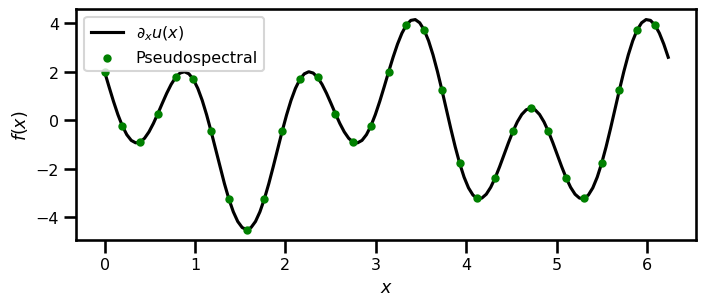

In [13]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(x_plot_coords, dudx_plot, linestyle="-", color="black", label=f"$\partial_x u(x)$")
ax.scatter(
    x_coords, dudx_sp[:], color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

### Functional API

In [14]:
from spectraldiffx._src.utils import calculate_fft_freq, calculate_aliasing, fft_transform
from spectraldiffx._src.difference import spectral_difference, difference


In [15]:

# calculate frequencies
k_vec = calculate_fft_freq(Nx, Lx)
cond = calculate_aliasing(k_vec)
k_vec = jnp.where(cond, 0.0, k_vec)

# forward transformation
Fu = fft_transform(u[:], axis=0, inverse=False)

# difference operator
dFudx = spectral_difference(Fu, k_vec, axis=0, derivative=1)

# # inverse transformation
dudx_spectral = fft_transform(dFudx, axis=0, inverse=True)


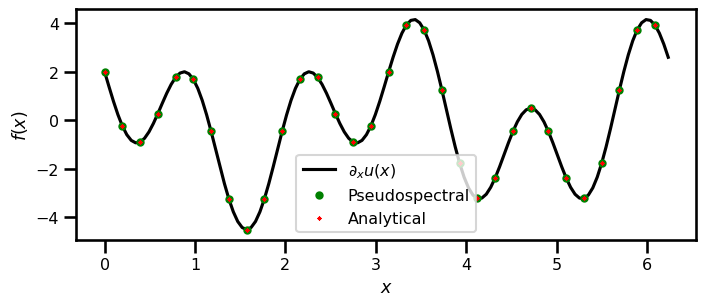

In [16]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(x_plot_coords, dudx_plot, linestyle="-", color="black", label=f"$\partial_x u(x)$")
ax.scatter(
    x_coords, dudx_spectral[:], color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.scatter(
    x_coords, dudx_analytical[:], color="red", marker="x", s=3, label=f"Analytical", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

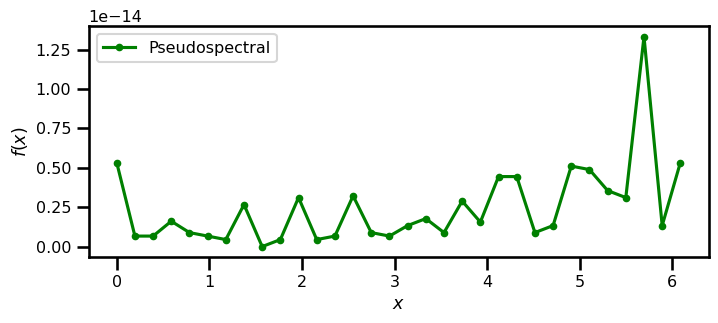

In [17]:
fig, ax = plt.subplots(figsize=(8,3))

ps_error = np.abs(dudx_spectral[:] - dudx_analytical[:])

ax.plot(x_coords, ps_error, color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

### Simpler API

In [18]:
# calculate frequencies
k_vec = calculate_fft_freq(Nx, Lx)

# pseudospectral transformation
dudx_spectral = difference(u[:], k_vec=k_vec, axis=0)

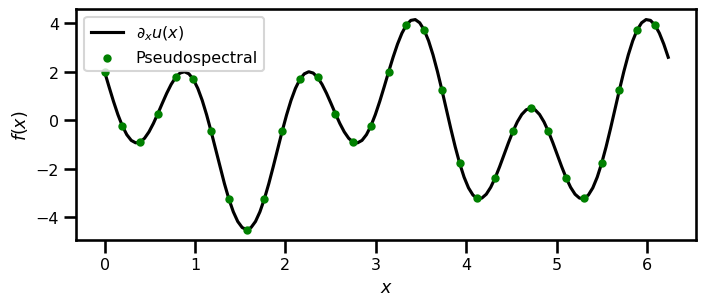

In [19]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(x_plot_coords, dudx_plot, linestyle="-", color="black", label=f"$\partial_x u(x)$")
ax.scatter(
    x_coords, dudx_spectral[:], color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

## Operator API

In [20]:
from typing import NamedTuple, Iterable, Optional
import math

class Difference(NamedTuple):
    k_vec: Iterable[Array]
    ratio: float
    aliasing_cond: Iterable[Array]

    @classmethod
    def init(
        cls,
        N: Iterable[float],
        L: Optional[Iterable[float]] = None,
        ratio: Optional[float] = 1.0 / 3.0,
    ):
        # calculate fourier frequencies
        if isinstance(N, (float, int)):
            N = tuple(N)

        if L is None:
            L = (2 * math.pi,) * len(N)
        elif isinstance(L, (int, float)):
            L = (float(L),) * len(N)

        assert len(N) == len(L)
        k_vec = [calculate_fft_freq(N=iN, L=iL) for iN, iL in zip(N, L)]
        ratio = ratio
        aliasing_cond = [calculate_aliasing(ikvec, ratio=ratio) for ikvec in k_vec]

        return cls(k_vec=k_vec, ratio=ratio, aliasing_cond=aliasing_cond)

    def get_k_vec(self, axis: int = 0, aliasing: bool = True):
        k_vec = self.k_vec[axis]

        if aliasing:
            k_vec = jnp.where(self.aliasing_cond[axis], 0.0, k_vec)

        return k_vec

    def difference(
        self,
        u: Array,
        axis: int = 0,
        derivative: int = 1,
        aliasing: bool = True,
    ) -> Array:
        k_vec = self.get_k_vec(axis=axis, aliasing=aliasing)
        return difference(u=u, k_vec=k_vec, axis=axis, derivative=derivative)

    def transform(self, u: Array, axis: int = 0) -> Array:
        return fft_transform(u=u, axis=axis, inverse=False)

    def inverse_transform(self, u: Array, axis: int = 0) -> Array:
        return fft_transform(u=u, axis=axis, inverse=True)

    def spectral_difference(
        self, fu: Array, axis: int = 0, derivative: int = 1
    ) -> Array:
        k_vec = self.get_k_vec(axis=axis, aliasing=aliasing)
        return spectral_difference(fu=fu, k_vec=k_vec, axis=axis, derivative=derivative)

In [21]:

diff_op = Difference.init(N=u.shape, L=[Lx], ratio=1.0/3.0)
dudx_spectral = diff_op.difference(u[:])

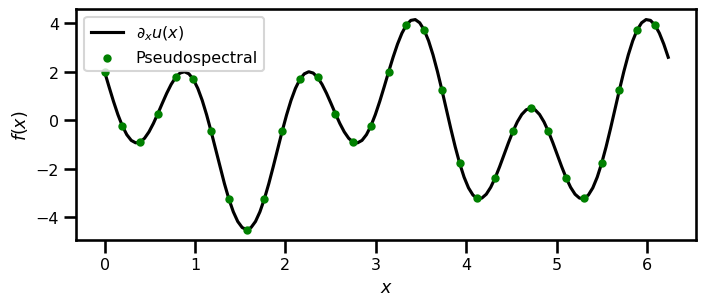

In [22]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(x_plot_coords, dudx_plot, linestyle="-", color="black", label=f"$\partial_x u(x)$")
ax.scatter(
    x_coords, dudx_spectral[:], color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

### 2nd Derivative

In [23]:
d2udx2_plot = jax.vmap(d2f)(x_plot_coords)
d2udx2_analytical = jax.vmap(d2f)(x_coords)

#### Pseudospectral

In [24]:
# derivative
d2udx2_spectral = diff_op.difference(u[:], derivative=2)
# d2udx2_spectral = F_spectral.difference_field(u=u_spectral, axis=0, derivative=2, real=True)


#### Viz: Derivatives

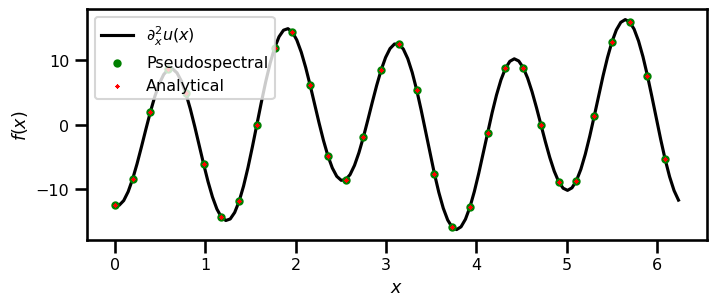

In [25]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(x_plot_coords, d2udx2_plot, linestyle="-", color="black", label=f"$\partial^2_x u(x)$")
ax.scatter(
    x_coords, d2udx2_spectral[:], color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.scatter(
    x_coords, d2udx2_analytical[:], color="red", marker="x", s=3, label=f"Analytical", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()

#### Visualization: Numerical Error

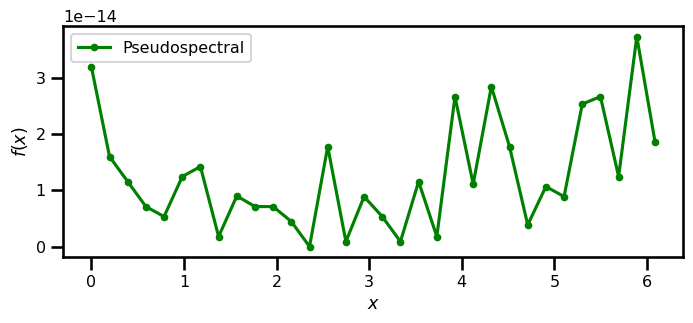

In [26]:
fig, ax = plt.subplots(figsize=(8,3))

ps_error = np.abs(d2udx2_spectral[:] - d2udx2_analytical[:])

ax.plot(x_coords, ps_error, color="green", marker=".", label=f"Pseudospectral", zorder=3)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
plt.legend()
plt.show()